In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import json  

#Config
data_path="../data/slack/"


fields = ['ts','user','parent_user_id','thread_ts']
value_name='Duration'

In [2]:
#Load data. This will try to load all json files in the selected path, assuming that if non slack json files will be loaded, the parsing of the json will fail.
#This is not the best way to do this, but it works well enough.
frames = []
files_counter=0
files_counter_wrong=0

for filename in glob.glob(data_path + '/**/*.json', recursive=True):
    try:
        
        df = pd.read_json(filename,orient='records')
        df = df[fields]
        frames.append(df)
        files_counter+=1
    except:
        files_counter_wrong+=1
print("Found",files_counter, "files containing slack data. Ignoring",files_counter_wrong, "json files without relevant data!")
        
data=pd.concat(frames)
data = data[data['thread_ts'].notna()]
data['ts']=(pd.to_datetime(data['ts'],unit='s')) 
data['thread_ts']=(pd.to_datetime(data['thread_ts'],unit='s')) 

Found 256 files containing slack data. Ignoring 123 json files without relevant data!


In [3]:
data['Duration'] = (data['ts']-data['thread_ts']).dt.seconds
data['hour'] = data['thread_ts'].dt.hour
data=data[data['Duration']>60] # exclude very fast responses (less than one minute)
data['Duration']=data['Duration']/60 #Convert duration column to minutes
data=data.drop_duplicates(subset=['user', 'thread_ts'], keep='first')
data = pd.get_dummies(data,columns=['user'])

data['hour_sin'] = np.sin(2 * np.pi * data['hour']/23.0)
data['hour_cos'] = np.cos(2 * np.pi * data['hour']/23.0)

#delete not needed columns
data = data.drop('ts', 1)
data = data.drop('parent_user_id', 1)
data = data.drop('thread_ts', 1)
data = data.drop('hour', 1)

,Duration,user_0l93idrnjb,user_3kl3vgfdzh,user_5cyvdwbyyg,user_7epjkqfmdn,user_8ujqppa72v,user_c960cfhnpq,user_cygqivx1jn,user_fechk4exyu,user_g7orerhcub,user_l3irkh4drd,user_mbhp3m2k5o,user_ok5m1vsbbz,user_tfqexmwt58,user_vxu42sqw1r,user_wuwubahv1t,hour_sin,hour_cos
1,18.266667,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,-0.997669,-0.068242
0,1013.733333,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.997669,-0.068242
0,58.233333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.997669,-0.068242
1,63.250000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.997669,-0.068242
5,191.300000,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.997669,-0.068242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,491.816667,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,-0.816970,-0.576680
0,1114.050000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.816970,-0.576680
1,1143.683333,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.816970,-0.576680
1,1.150000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.631088,-0.775711


In [4]:
#Just to see how large the data-set is we are working with.
print('The shape of our features is:', data.shape)


The shape of our features is: (810, 18)


In [5]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

x = data.drop(value_name, 1)
y = data[value_name]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [6]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 0,criterion='mae')# Train the model on training data
rf.fit(x_train, y_train);

In [7]:
predictions = rf.predict(x_test)# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))
# Print out the maximum error
print('Max Error: ',np.max(errors),".")

Mean Absolute Error: 307.11
Max Error:  1364.3691166666665 .


In [8]:
# build input data for every user, containing every hour of the day to be predicted later.
# There Could be a nicer way to do this, but this is working fine
complete_set = []
for i in range(0,len(x_test.columns)-2):
    for hour in range(0,24):
        elem=[0]*(len(x_test.columns))
        elem[-1]=np.cos(2 * np.pi * hour/23.0)
        elem[-2]=np.sin(2 * np.pi * hour/23.0)
        elem[i]=1
        complete_set.append(elem)
data_all_predicted = pd.DataFrame(data=complete_set, columns=x_test.columns)
pred_all = rf.predict(data_all_predicted)
complete = data_all_predicted.assign(duration=pred_all)

#we can assume that the hours will be from 0 to 23 for each user, and repeat with the next.
hours=list(range(0,24))*int(len(complete.index)/24)
complete['hour']=hours
data = data.drop('hour_sin', 1)
data = data.drop('hour_cos', 1)

# Put the prediction results into a data structure that is easy to serialize to json.

res = {} # Result to be serialized, dictionary with the keys "id" "name" and "response_time" Datatype for the values varies!

username_dict = {}

with open(data_path+'users.json', 'r') as myfile:
    obj = json.loads(myfile.read())
    for user in obj:
        username_dict[user['id']]=user['name']

for (idx,row) in complete.iterrows():
    hour=row['hour']
    duration=row['duration']
    user =""
    for (name,field) in row.items():
        if not user in name:
            continue
        if field == 1:
            user=name
            break
    user=user.replace("user_","")
    if not user in res:
        res[user]={"id":user,"name":username_dict[user], "response_time":{}}
    res[user]["response_time"][hour]=duration

with open('result.json', 'w') as outfile:
    json.dump(list(res.values()),outfile)

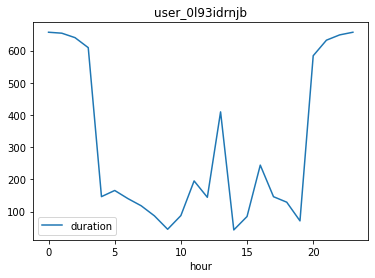

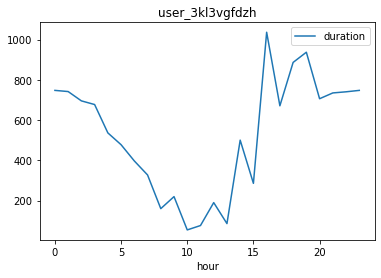

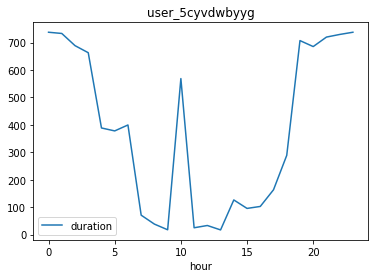

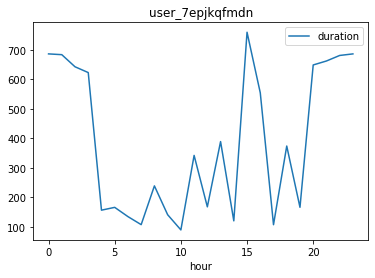

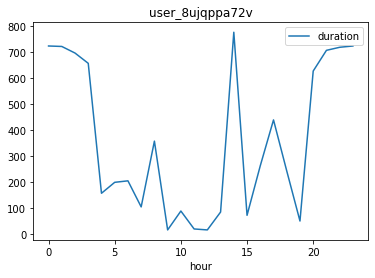

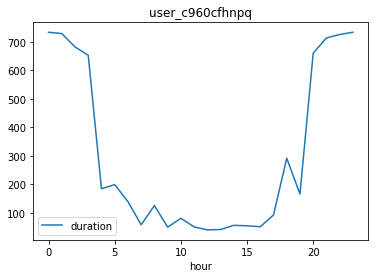

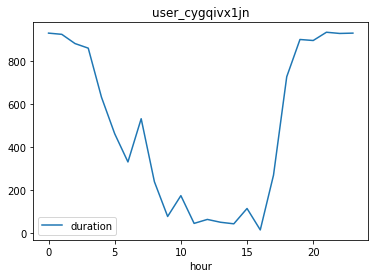

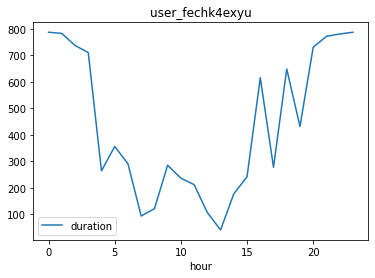

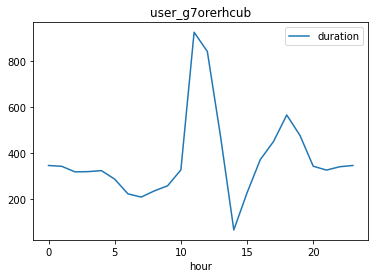

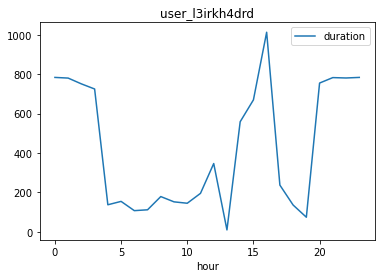

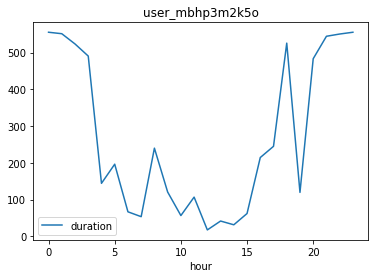

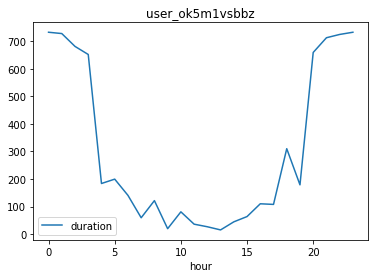

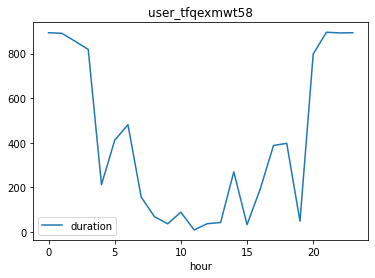

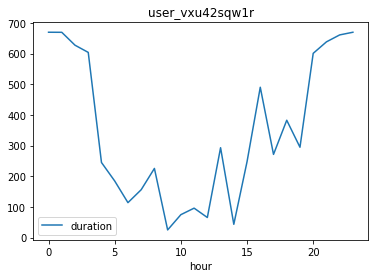

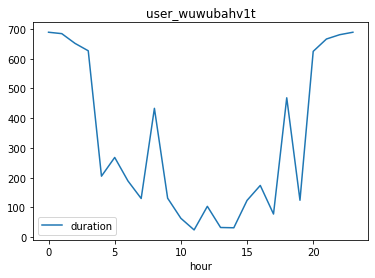

In [9]:
#Display the prediction. This is only relevant for debugging, as the result was already saved!
for user in data_all_predicted.columns:
    if not 'hour' in user:
        example=complete[complete[user]==1]
        example.plot(x='hour',y='duration',title=user)